# Completed Part 1 of HW 8. 

![](dynamics.png)

**Dynamics** are the fundamental building blocks of neurons in `lava.dl.lib.slayer`.  Dynamics: custom __CUDA__ accelerated, __fixed precision__ compatible, and __PyTorch autogard__ compatible with _learnable decay(s)_ and _persistent state(s)_.

**Dynamics scaling:** the internal dynamics computation are done in fixed precision range. However, the parameters and state can be interpreted in scaled representation. This has two advantages. 

* First, the dynamics are scaled such that the backpropagation gradients are usually in proper range for good gradient flow thus eliminating the need for unnatural scaling of surrogate gradients.
* Second, the states and decays are in intuitive range rather than in abstract scaled fixed point state.

### Notations:
Following notation for variable is used in this notebook.

| Notation | Variable |
|----------|----------|
| $x[t]$   | input    |
| $y[t]$   | state variable |
| $\vartheta[t]$ | threshold |
| $r[t]$   | refractory state |
| $s[t]$   | spike flag |
| $\alpha$ | leak parameter |
| $\phi$   | phase shift |

**NOTE:** this is a deep dive tutorial. It introduces
* neuron dynamics in SLAYER.
* how some available neurons are implemented.
* how one can use these dynamics to build their custom neuron model.
* real and complex spike mechanism in SLAYER.

*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# MNIST Digit Classification with Lava

_**Motivation**: In this tutorial, we will build a Lava Process for an MNIST
classifier, using the Lava Processes for LIF neurons and Dense connectivity.
The tutorial is useful to get started with Lava in a few minutes._


#### Our MNIST Classifier
Build a multi-layer feed-forward classifier without
 any convolutional layers. The architecture is shown below.

> **Important Note**:
>
> The classifier is a simple feed-forward model using pre-trained network 
> parameters (weights and biases). It illustrates how to build, compile and 
> run a functional model in Lava. Please refer to 
> [Lava-DL](https://github.com/lava-nc/lava-dl) to understand how to train 
> deep networks with Lava.

<center><img src="https://raw.githubusercontent.com/lava-nc/lava-nc.github.io/main/_static/images/tutorial01/mnist_process_arch.png" alt="MNIST Process AA"
style="width: 800px;"/></center>

The 3 Processes shown above are:
 - *SpikeInput* Process - generates spikes via integrate and fire dynamics,
 using the image input
 - *ImageClassifier* Process - encapsulates feed-forward architecture of
 Dense connectivity and LIF neurons
 - *Output* Process - accumulates output spikes from the feed-forward process
and infers the class label

#### General Imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import lava.lib.dl.slayer as slayer

# Parameter setup

## Select Device

In [23]:
device = torch.device('cpu') #my laptop
# device = torch.device('cuda')

## Setup weighted spike input

In [24]:
time = np.arange(1000)
t = torch.FloatTensor(time).to(device)
input = torch.zeros_like(t)
for tt, ww in [[10, 2], [97, 2.8], [100, 1.6], [267, -3], [500, 1], [505, 1], [510, 1], [515, 1],
[520,1]]:
    input[tt] = ww

## Set dynamics decay and state

In [25]:
scale = 1<<12 # scale factor for integer simulation
decay = torch.FloatTensor([0.1 * scale]).to(device)
initial_state = torch.FloatTensor([0]).to(device)
threshold = 1.5

# Dynamics

## 1. Leaky integrator

Leaky integrator is the basic first order neuron dynamics represented by the following discrete system:

_state dynamics_: $y[t] = (1-\alpha)\,y[t-1] + x[t]$

_spike dynamics_: $s[t] = y[t] \geq \vartheta$

_reset dynamics_: $y[t] = 0$

Leaky integrator dynamics can be cascaded with other dynamics to form a second order neuron like CUBA neuron and other higer order neurons.

In [26]:
y = slayer.neuron.dynamics.leaky_integrator.dynamics(input, decay=decay, state=initial_state, w_scale=scale, threshold=threshold)

#### 1.0.1 Spike 

Fully backpropagable spike mechanism is avalilable as `slayer.spike.Spike`. It supports binary as well as graded spikes.

In [27]:
sp = slayer.spike.Spike.apply(
        y, 
        threshold, 
        1, # tau_rho: gradient relaxation constant 
        1, # scale_rho: gradient scale constant
        False, # graded_spike: graded or binary spike 
        0, # voltage_last: voltage at t=-1
        1, # scale: graded spike scale 
    )

### 1.1 CUrrent BAsed (CUBA) leaky integrate and fire (LIF) neuron

A CUBA-LIF neuron is simply the leaky integrator dynamics applied to current followed by voltage. For easy usage, CUBA neuron is avaliable as __`slayer.neuron.cuba`__.

In [28]:
second_order_th = threshold * 5
current = slayer.neuron.dynamics.leaky_integrator.dynamics(input, decay=decay, state=initial_state, w_scale=scale)
voltage = slayer.neuron.dynamics.leaky_integrator.dynamics(current, decay=decay, state=initial_state, w_scale=scale, threshold=second_order_th)

### 1.2 Plot results 

Text(0.5, 0, 'time')

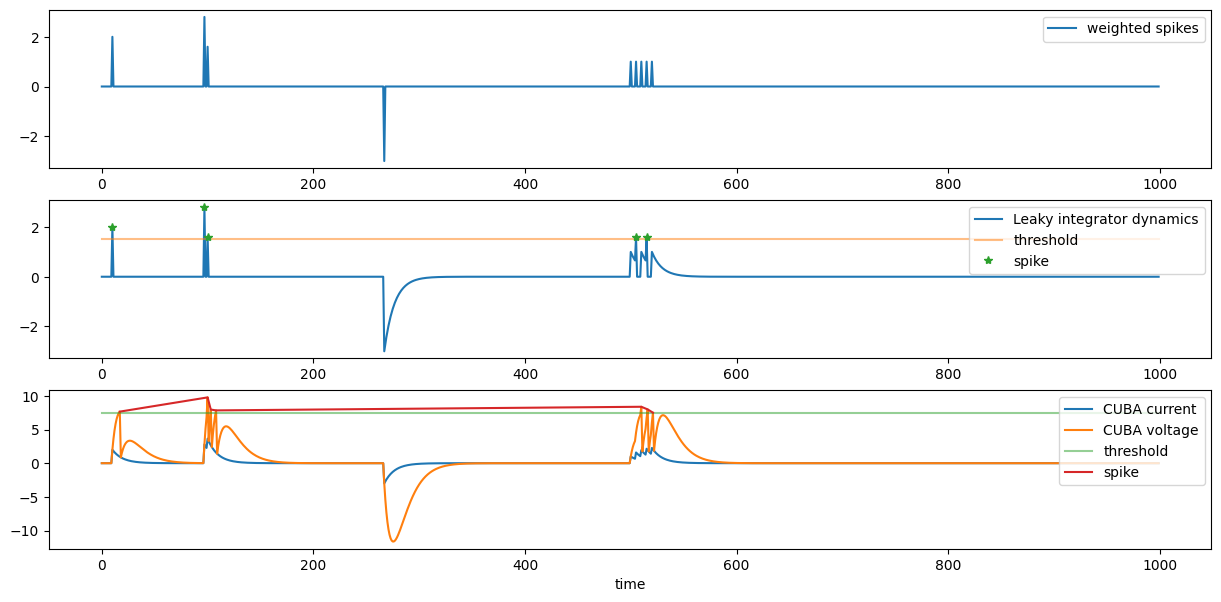

In [29]:
fig,ax = plt.subplots(3, 1, figsize=(15, 7))
ax[0].plot(time, input.cpu(), label='weighted spikes')
ax[0].legend(loc='upper right')

ax[1].plot(time, y.cpu(), label='Leaky integrator dynamics')
ax[1].plot(time, threshold * np.ones_like(time), alpha=0.5, label='threshold')
ax[1].plot(time[sp>0], y[sp>0], '*', label='spike')
ax[1].legend(loc='upper right')

ax[2].plot(time, current.cpu(), label='CUBA current')
ax[2].plot(time, voltage.cpu(), label='CUBA voltage')
ax[2].plot(time, second_order_th * np.ones_like(time), alpha=0.5, label='threshold')
ax[2].plot(time[voltage>second_order_th], voltage[voltage>second_order_th].cpu(), label='spike')
ax[2].legend(loc='upper right')

ax[-1].set_xlabel('time')

## 2. Adaptive Threshold Dynamics

Adaptive threshold dynamics provides first order threshold adaptation and refractory state adaptation dynamics. 

_threshold dynamics_: $\vartheta[t] = (1-\alpha_{\vartheta})\,(\vartheta[t-1] - \vartheta_0) + \vartheta_0$

_refractory dynamics_: $r[t] = (1-\alpha_r)\,r[t-1]$

_spike dynamics_: $s[t] = (x[t] - r[t]) \geq \vartheta[t]$

_post spike dynamics_: $r[t] = r[t] + 2\,\vartheta[t]$ and
$\vartheta[t] = \vartheta[t] + \vartheta_{\text{step}}$

### 2.1 Adaptive Leaky Integrator and Fire Neuron

When coupled with a second order leaky integrator, it results in second order adaptive leaky integartor neuron. For easy usage, ALIF neuron is avaliable as __`slayer.neuron.alif`__.

In [30]:
current = slayer.neuron.dynamics.leaky_integrator.dynamics(input, decay=decay, state=initial_state, w_scale=scale)
voltage = slayer.neuron.dynamics.leaky_integrator.dynamics(current, decay=decay, state=initial_state, w_scale=scale)
th, ref = slayer.neuron.dynamics.adaptive_threshold.dynamics(
        voltage,                      # dynamics state
        ref_state=initial_state,      # previous refractory state
        ref_decay=0.5*decay,          # refractory decay
        th_state=initial_state + second_order_th, # previous threshold state
        th_decay=decay,               # threshold decay
        th_scale=0.5*second_order_th, # threshold step
        th0=second_order_th,          # threshold stable state
        w_scale=scale                 # fixed precision scaling
    )

### 2.2 Plot results 

Text(0.5, 0, 'time')

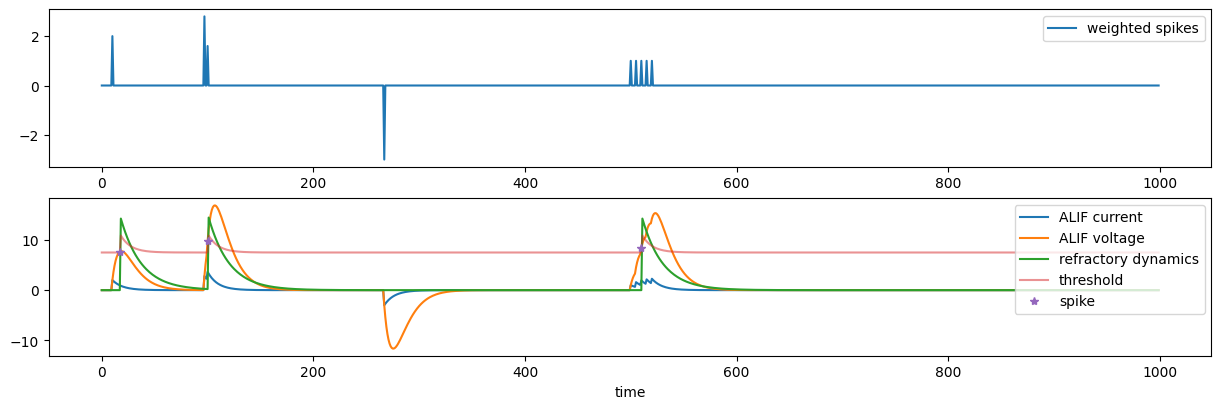

In [31]:
fig,ax = plt.subplots(2, 1, figsize=(15, 4.5))
ax[0].plot(time, input.cpu(), label='weighted spikes')
ax[0].legend(loc='upper right')

ax[1].plot(time, current.cpu(), label='ALIF current')
ax[1].plot(time, voltage.cpu(), label='ALIF voltage')
ax[1].plot(time, ref.cpu(), label='refractory dynamics')
ax[1].plot(time, th.cpu(), alpha=0.5, label='threshold')
ax[1].plot(time[(voltage-ref)>th], voltage[(voltage-ref)>th], '*', label='spike')
ax[1].legend(loc='upper right')

ax[-1].set_xlabel('time')

Study the plots to note down when the neuron spikes and describe the difference in
behavior between the CuBA LIF neuron and Adaptive LIF neuron. Which one spikes more?
Why? (10 pts)

The CuBA neuron is the first neruon and the Adaptive LIF neuron is seen second on this page. The adaptive LIF fires 3 times compared to the CuBA one time firing. This occurs when threshold voltage is surpased. The CuBA is first order while the Adaptive LIF is second order. This means the second order neuron can handle more complex information and thus can spike more because it can itegrate and orocessing information from more than one sources. Essentially, it can display more pattern recognition due to the more complex modeling, as can be seen by the spike counts in both. 


NOT APPLICABLE TO HW 8 PART 1: Resonator

Resonator is first order complex leaky dynamics. The leak is, in general, complex and gives rise to oscillatory dynamics.
The resonator dynamics is described by
$$
\frac{\text dz}{\text dt} = (-\lambda + i\omega)\,z + \zeta
$$
where $\zeta \in \mathbb{R}^n$ is the complex input to the system, $\lambda, \omega \in R^+$. 

**Discretization**

The impulse response of resonator is 
$$ h(t) = e^{-\lambda t}\,e^{i\omega t}\,\mathcal H(t) $$
The coresponding discrete system has the impulse respnse
$$ h[n] = e^{-\lambda n \Delta t}\,e^{i\omega n \Delta t}\,\mathcal H[n] =  (e^{-\lambda \Delta t}\,e^{i\omega \Delta t})^n\,\mathcal H[n] = e^{-\lambda \Delta t}\,e^{i\omega \Delta t} h[n-1],\ h[0]=1$$

The equivalent discrete system is therefore
$$z[n + 1] = e^{-\lambda \Delta t}\,e^{i\omega \Delta t}\,z[n] + \zeta[n]$$

The complex decay can be decoupled as

_magnitude leak_: $\alpha = 1 - e^{-\lambda \Delta t}$

_phase shift_: $\phi = e^{i\omega \Delta t}$

_decay matrix_: $(1-\alpha)\begin{bmatrix} \cos\phi &-\sin\phi \\ \sin\phi &\cos\phi\end{bmatrix}$

### 3.1 Resonate and Fire (RF) neuron

A resonate and fire neuron spikes when it's internal state crosses the real axis in the positive real half plane greater than the neuron's theshold, $\vartheta$. Formally, it can be stated as follows.
$$
f_s(z) = \mathcal{H}(\mathfrak{Re}(z) - \vartheta)\,\delta(\mathfrak{Im}(z))
$$
or equivalently
$$
f_s(z) = \mathcal{H}(|z| - \vartheta)\,\delta(\arg(z))
$$

For easy usage, RF neuron is avaliable as __`slayer.neuron.rf`__.

In [32]:
re_input = input
im_input = 2*torch.randn_like(re_input) * (re_input > 0)
alpha = torch.FloatTensor([0.03 * scale]).to(device)
phi = 2 * np.pi /25
sin_decay = (scale-alpha) * np.sin(phi)
cos_decay = (scale-alpha) * np.cos(phi)
re, im = slayer.neuron.dynamics.resonator.dynamics(
        re_input, im_input, 
        sin_decay, cos_decay, 
        real_state=initial_state, 
        imag_state=initial_state, 
        w_scale=scale,
    )


#### 3.1.1 Complex spike

Fully backpropagable complex spike mechanism supporting phase spiking mechanism of RF neuron is avalilable as `slayer.spike.complex.Spike`. It supports binary as well as graded spikes.

_spike dynamics_: $|z[t]| \geq \vartheta$ and $\arg(z[t]) = 0$

In [33]:
sp = slayer.spike.complex.Spike.apply(
        re, im, 
        threshold,
        1, # tau_rho: gradient relaxation constant 
        1, # scale_rho: gradient scale constant
        False, # graded_spike: graded or binary spike 
        0, # voltage_last: voltage at t=-1
        1, # scale: graded spike scale 
    )

In [34]:
iz_re, iz_im = slayer.neuron.dynamics.resonator.dynamics(
        re_input, im_input, 
        sin_decay, cos_decay, 
        real_state=initial_state, 
        imag_state=initial_state, 
        w_scale=scale,
        threshold=threshold,
    )

### 3.3 Second Order RF neuron

Two resonator dynamics can be cascaded to produce Gammatone like second order resonator dynamics. In theory, it could also be combined with leaky integrator for even more exotic neuron model.

In [35]:
second_order_th = threshold * 15
re_0, im_0 = slayer.neuron.dynamics.resonator.dynamics(
        re_input, im_input, 
        sin_decay, cos_decay, 
        real_state=initial_state, 
        imag_state=initial_state, 
        w_scale=scale,
    )
re_1, im_1 = slayer.neuron.dynamics.resonator.dynamics(
        re_0, im_0, 
        sin_decay, cos_decay, 
        real_state=initial_state, 
        imag_state=initial_state, 
        w_scale=scale,
    )
sp_1 = slayer.spike.complex.Spike.apply(re_1, im_1, second_order_th, 1, 1, False, 0, 1)

### 3.4 Plot results 

Text(0.5, 0, 'time')

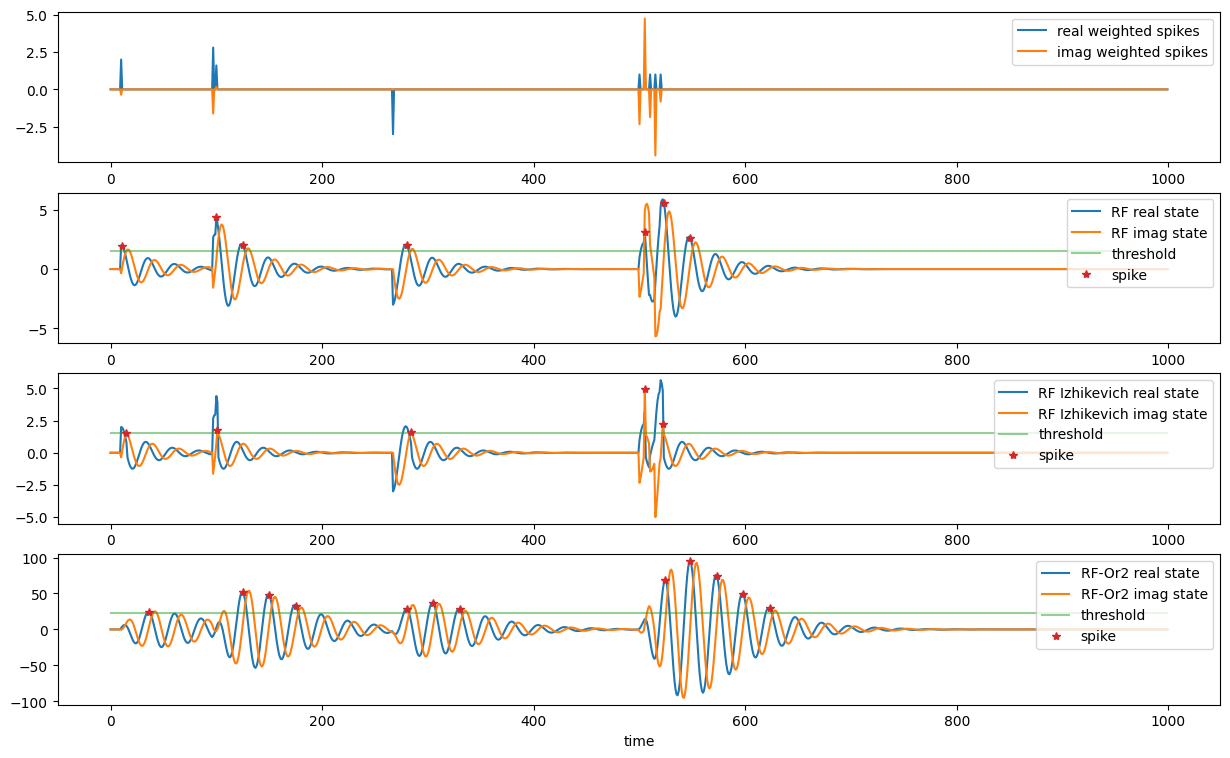

In [36]:
fig,ax = plt.subplots(4, 1, figsize=(15, 9))
ax[0].plot(time, re_input.cpu(), label='real weighted spikes')
ax[0].plot(time, im_input.cpu(), label='imag weighted spikes')
ax[0].legend(loc='upper right')

ax[1].plot(time, re.cpu(), label='RF real state')
ax[1].plot(time, im.cpu(), label='RF imag state')
ax[1].plot(time, threshold * np.ones_like(time), alpha=0.5, label='threshold')
ax[1].plot(time[sp>0], re[sp>0], '*', label='spike')
ax[1].legend(loc='upper right')

ax[2].plot(time, iz_re.cpu(), label='RF Izhikevich real state')
ax[2].plot(time, iz_im.cpu(), label='RF Izhikevich imag state')
ax[2].plot(time, threshold * np.ones_like(time), alpha=0.5, label='threshold')
ax[2].plot(time[iz_im > threshold], iz_im[iz_im > threshold], '*', label='spike')
ax[2].legend(loc='upper right')

ax[3].plot(time, re_1.cpu(), label='RF-Or2 real state')
ax[3].plot(time, im_1.cpu(), label='RF-Or2 imag state')
ax[3].plot(time, second_order_th * np.ones_like(time), alpha=0.5, label='threshold')
ax[3].plot(time[sp_1>0], re_1[sp_1>0], '*', label='spike')
ax[3].legend(loc='upper right')

ax[-1].set_xlabel('time')

In [37]:
def plot_phase_region(ax, threshold, sin_decay):
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xx = np.array([threshold, threshold+500])
    yy = xx * sin_decay
    ax.fill_between(xx, yy, color='green', alpha=0.1)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
def plot_iz_region(ax, threshold):
    ylims = ax.get_ylim()
    ax.axhspan(threshold, threshold+50, color='green', alpha=0.1)
    ax.set_ylim(ylims)

Text(0.5, 1.0, 'RF-Or2')

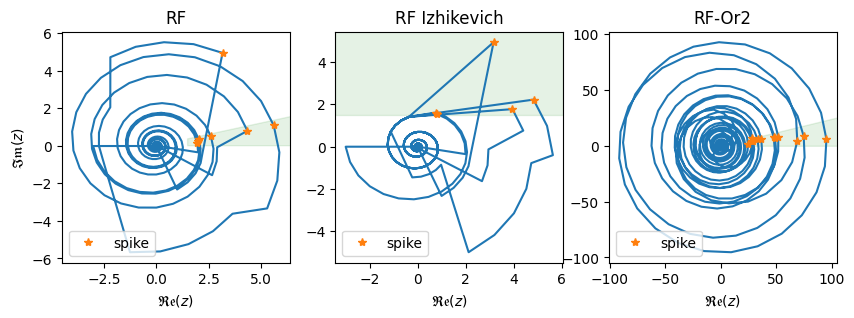

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].plot(re.cpu(), im.cpu())
ax[0].plot(re[sp>0], im[sp>0], '*', label='spike')
plot_phase_region(ax[0], threshold, sin_decay.item()/scale)
ax[0].set_xlabel('$\mathfrak{Re}(z)$')
ax[0].set_ylabel('$\mathfrak{Im}(z)$')
ax[0].legend(loc='lower left')
ax[0].set_title('RF')
ax[1].plot(iz_re.cpu(), iz_im.cpu())
ax[1].plot(iz_re[iz_im > threshold], iz_im[iz_im > threshold], '*', label='spike')
plot_iz_region(ax[1], threshold)
ax[1].set_xlabel('$\mathfrak{Re}(z)$')
ax[1].legend(loc='lower left')
ax[1].set_title('RF Izhikevich')

ax[2].plot(re_1.cpu(), im_1.cpu())
ax[2].plot(re_1[sp_1>0], im_1[sp_1>0], '*', label='spike')
plot_phase_region(ax[2], second_order_th, sin_decay.item()/scale)
ax[2].set_xlabel('$\mathfrak{Re}(z)$')
ax[2].legend(loc='lower left')
ax[2].set_title('RF-Or2')

## 4. Adaptive Resonator

Adaptive resonator adds adaptive threshold and refractory dynamics on top of resonator. Two flavors of adaptive resonator dynamics are available in SLAYER: `slayer.neuron.dynamics.phase_th` and `slayer.neuron.dynamics.adaptive_resonator` corresponding to __phase spiking__ and __Izhikevich spiking__ mechanisms respectively.
Both dynamics follow the same post spike dynamics.

_post spike dynamics_: $r[t] = r[t] + 2\,\vartheta[t]$ and $\vartheta[t] = \vartheta[t] + \vartheta_{\text{step}}$

### 4.1 Adaptive Resonate and Fire (AdRF) neuron

AdRF neuron spikes when its state crosses zero phase with real value higher than refractory dynamics and threshold dynamics combined. 

_spike dynamics_: $|z[t]| \geq (\vartheta[t] + r[t])$ and $\arg(z[t]) = 0$

For easy usage, AdRF neuron is avaliable as __`slayer.neuron.adrf`__.

In [39]:
adrf_re, adrf_im = slayer.neuron.dynamics.resonator.dynamics(
        re_input, im_input, 
        sin_decay, cos_decay, 
        real_state=initial_state, 
        imag_state=initial_state, 
        w_scale=scale,
    )
adrf_th, adrf_ref = slayer.neuron.dynamics.adaptive_phase_th.dynamics(
        adrf_re, adrf_im, 
        im_state=initial_state, # only imaginary state is needed to determine first phase crossing
        ref_state=initial_state, ref_decay=0.5*decay,       # refractory state and decay
        th_state=initial_state + threshold, th_decay=decay, # threshold state and decay
        th_scale=0.5 * threshold, # threshold step
        th0=threshold,          # threshold stable state
        w_scale=scale,
    )
adrf_sp = slayer.spike.complex.Spike.apply(
        adrf_re, adrf_im, adrf_th + adrf_ref,
        1, # tau_rho: gradient relaxation constant 
        1, # scale_rho: gradient scale constant
        False, # graded_spike: graded or binary spike 
        0, # voltage_last: voltage at t=-1
        1, # scale: graded spike scale 
    )

### 4.2 Adaptive Resonate and Fire Izhikevich (AdRF-Iz) neuron

AdRF-Iz neuron fires when the imaginary state exceeds the threshold and refractory dynamics. There is no hard reset in this model. 

_spike dynamics_: $\mathfrak{Im}(z[t]) \geq (\vartheta[t] + r[t])$

For easy usage, AdRF-Iz neuron is avaliable as __`slayer.neuron.adrf_iz`__.

In [40]:
adrf_iz_re, adrf_iz_im, adrf_iz_th, adrf_iz_ref = slayer.neuron.dynamics.adaptive_resonator.dynamics(
        re_input, im_input, 
        sin_decay, cos_decay, ref_decay=0.5*decay, th_decay=decay,
        real_state=initial_state, 
        imag_state=initial_state,
        ref_state=initial_state,
        th_state=initial_state + threshold,
        th_scale=0.5 * threshold, # threshold step
        th0=threshold,          # threshold stable state
        w_scale=scale,
    )

adrf_iz_sp = adrf_iz_im > (adrf_iz_th + adrf_iz_ref)

### 4.3 Plot results 

Text(0.5, 0, 'time')

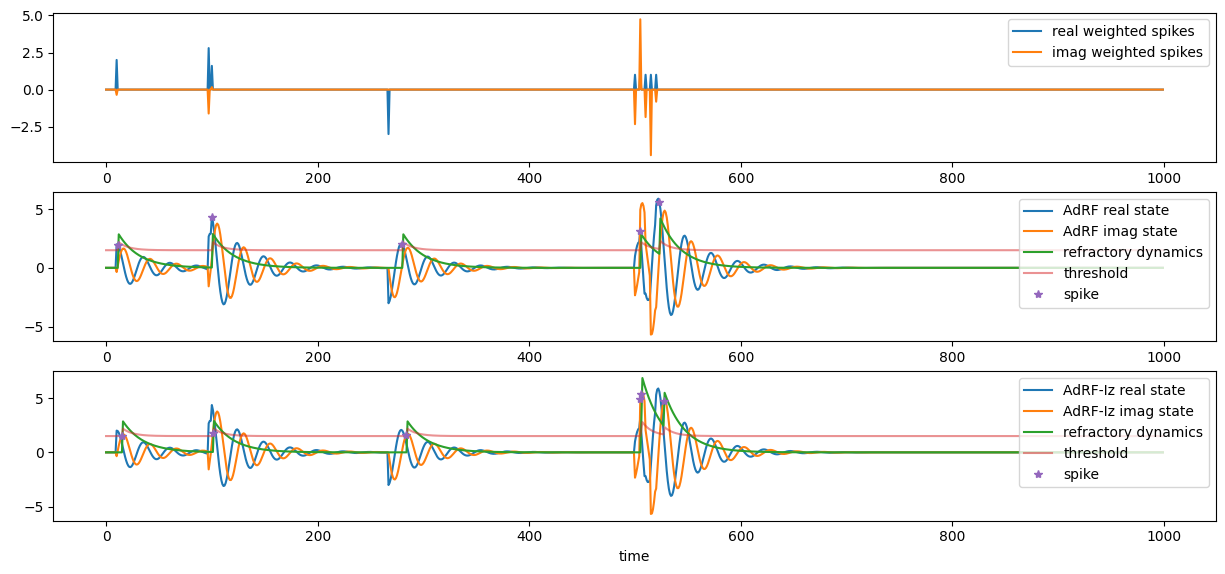

In [41]:
fig,ax = plt.subplots(3, 1, figsize=(15, 6.6))
ax[0].plot(time, re_input.cpu(), label='real weighted spikes')
ax[0].plot(time, im_input.cpu(), label='imag weighted spikes')
ax[0].legend(loc='upper right')

ax[1].plot(time, adrf_re.cpu(), label='AdRF real state')
ax[1].plot(time, adrf_im.cpu(), label='AdRF imag state')
ax[1].plot(time, adrf_ref.cpu(), label='refractory dynamics')
ax[1].plot(time, adrf_th.cpu(), alpha=0.5, label='threshold')
ax[1].plot(time[adrf_sp>0], adrf_re[adrf_sp>0], '*', label='spike')
ax[1].legend(loc='upper right')

ax[2].plot(time, adrf_iz_re.cpu(), label='AdRF-Iz real state')
ax[2].plot(time, adrf_iz_im.cpu(), label='AdRF-Iz imag state')
ax[2].plot(time, adrf_iz_ref.cpu(), label='refractory dynamics')
ax[2].plot(time, adrf_iz_th.cpu(), alpha=0.5, label='threshold')
ax[2].plot(time[adrf_iz_sp], adrf_iz_im[adrf_iz_sp], '*', label='spike')
ax[2].legend(loc='upper right')

ax[-1].set_xlabel('time')

Text(0.5, 1.0, 'AdRF Izhikevich')

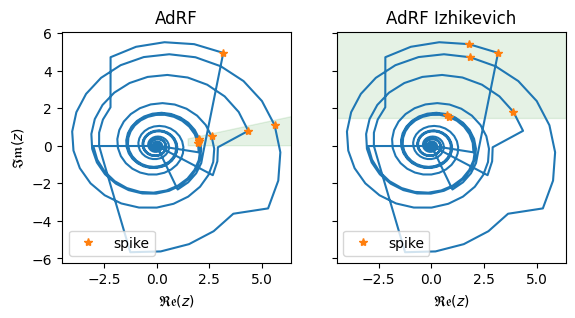

In [42]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 2, figsize=(6.5, 3), sharey=True)
ax[0].plot(adrf_re.cpu(), adrf_im.cpu())
ax[0].plot(adrf_re[sp>0], adrf_im[sp>0], '*', label='spike')
plot_phase_region(ax[0], threshold, sin_decay.item()/scale)
ax[0].set_xlabel('$\mathfrak{Re}(z)$')
ax[0].set_ylabel('$\mathfrak{Im}(z)$')
ax[0].legend(loc='lower left')
ax[0].set_title('AdRF')

ax[1].plot(adrf_iz_re.cpu(), adrf_iz_im.cpu())
ax[1].plot(adrf_iz_re[adrf_iz_sp], adrf_iz_im[adrf_iz_sp], '*', label='spike')
plot_iz_region(ax[1], threshold)
ax[1].set_xlabel('$\mathfrak{Re}(z)$')
ax[1].legend(loc='lower left')
ax[1].set_title('AdRF Izhikevich')